<a href="https://colab.research.google.com/github/ReynadelYolo/ML_Projects/blob/main/Chatbot_Analytics_V1_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets sweetviz

from datasets import load_dataset


dataset = load_dataset("electricsheepafrica/nigerian-telecom-chatbot-and-live-chat-logs")

print(dataset)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 98.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

chatbot_and_live_chat_logs.parquet:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session_id', 'session_start', 'session_end', 'duration_seconds', 'customer_id', 'operator', 'channel', 'intent', 'handled_by', 'escalated_to_human', 'message_count', 'resolved', 'customer_satisfaction', 'language'],
        num_rows: 400000
    })
})


In [2]:
import pandas as pd

# Convert the 'train' split to a Pandas DataFrame
df = dataset['train'].to_pandas()

# Display the first few rows
df.head()

,session_id,session_start,session_end,duration_seconds,customer_id,operator,channel,intent,handled_by,escalated_to_human,message_count,resolved,customer_satisfaction,language
0,CHAT00000001,2025-09-16 06:01:00,2025-09-16 06:02:47,107,CUST5465481,MTN,whatsapp,port_number,bot,False,14,True,5,english
1,CHAT00000002,2025-09-03 00:38:00,2025-09-03 00:42:49,289,CUST7117483,Airtel,app,port_number,bot,False,21,True,5,english
2,CHAT00000003,2025-09-09 01:23:00,2025-09-09 01:36:55,835,CUST4948915,MTN,app,port_number,human,True,6,True,3,english
3,CHAT00000004,2025-09-04 11:21:00,2025-09-04 11:33:36,756,CUST1858299,MTN,app,recharge_issue,human,True,25,True,4,english
4,CHAT00000005,2025-09-13 03:09:00,2025-09-13 03:11:11,131,CUST8344247,Airtel,web,port_number,bot,False,18,True,1,pidgin


In [3]:
# Access the first row
print(dataset['train'][0])

# Access a specific column
print(dataset['train']['language'][:5])

{'session_id': 'CHAT00000001', 'session_start': Timestamp('2025-09-16 06:01:00'), 'session_end': Timestamp('2025-09-16 06:02:47'), 'duration_seconds': 107, 'customer_id': 'CUST5465481', 'operator': 'MTN', 'channel': 'whatsapp', 'intent': 'port_number', 'handled_by': 'bot', 'escalated_to_human': False, 'message_count': 14, 'resolved': True, 'customer_satisfaction': 5, 'language': 'english'}
['english', 'english', 'english', 'english', 'pidgin']


In [4]:
print(f"Dataset Shape: {df.shape}")
df.info() # Check for nulls and data types

Dataset Shape: (400000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   session_id             400000 non-null  object        
 1   session_start          400000 non-null  datetime64[ns]
 2   session_end            400000 non-null  datetime64[ns]
 3   duration_seconds       400000 non-null  int64         
 4   customer_id            400000 non-null  object        
 5   operator               400000 non-null  object        
 6   channel                400000 non-null  object        
 7   intent                 400000 non-null  object        
 8   handled_by             400000 non-null  object        
 9   escalated_to_human     400000 non-null  bool          
 10  message_count          400000 non-null  int64         
 11  resolved               400000 non-null  bool          
 12  customer_satisfa

In [18]:
# ==================== ADD SYNTHETIC DEMOGRAPHIC DATA ====================
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1. SEX
df['sex'] = df['session_id'].apply(lambda x: 'Male' if hash(x) % 100 < 55 else 'Female')

# 2. AGE (18-65, skewed younger)
df['age'] = df['session_id'].apply(lambda x: int(18 + (hash(x) % 1000) / 1000 * 47 * (1 - (hash(x) % 500) / 1000)))

# 3. ZONE (Nigeria geopolitical zones)
zones = ['South West', 'North West', 'North Central', 'South South', 'South East', 'North East']
zone_weights = [0.28, 0.22, 0.16, 0.14, 0.12, 0.08]

def assign_zone(session_id):
    np.random.seed(RANDOM_SEED + hash(session_id) % 10000)
    return np.random.choice(zones, p=zone_weights)

df['zone'] = df['session_id'].apply(assign_zone)

# 4. MONTH (from session_start)
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
month_weights = [0.05, 0.05, 0.06, 0.08, 0.10, 0.12, 0.12, 0.11, 0.10, 0.08, 0.07, 0.06]

def assign_month(session_id):
    np.random.seed(hash(session_id) % 10000)
    return np.random.choice(months, p=month_weights)

df['month'] = df['session_id'].apply(assign_month)

print(df['month'].value_counts())

month
June         48858
August       45613
July         44683
September    40574
May          39490
October      32372
April        29873
November     27887
March        24900
December     24090
January      20834
February     20826
Name: count, dtype: int64


In [12]:
# ==================== FEATURE ENGINEERING ====================
# Input: 19 columns (14 original + 5 synthetic)
# Output: +18 engineered features

# ----- TIME FEATURES -----
df['response_latency'] = df['duration_seconds'] / df['message_count']
df['hour'] = df['session_start'].dt.hour
df['day_of_week'] = df['session_start'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['time_period'] = pd.cut(df['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True)

# ----- USER BEHAVIOR FEATURES -----
df['session_count'] = df.groupby('customer_id')['session_id'].transform('count')
df['is_recurring_user'] = (df['session_count'] > 1).astype(int)
df['is_long_session'] = (df['duration_seconds'] > df['duration_seconds'].median()).astype(int)

# ----- BOT PERFORMANCE -----
df['bot_resolved'] = ((df['handled_by'] == 'bot') & df['resolved']).astype(int)

# ----- CATEGORICAL FEATURES -----
df['satisfaction_tier'] = pd.cut(df['customer_satisfaction'],
    bins=[0, 2, 3, 5],
    labels=['Detractor', 'Passive', 'Promoter'])

df['age_group'] = pd.cut(df['age'],
    bins=[18, 25, 35, 45, 55, 65],
    labels=['18-25', '26-35', '36-45', '46-55', '56-65'])

# ----- AGGREGATED METRICS (ORIGINAL DATA) -----
df['operator_resolution_rate'] = df.groupby('operator')['resolved'].transform('mean')
df['channel_resolution_rate'] = df.groupby('channel')['resolved'].transform('mean')
df['intent_complexity'] = df.groupby('intent')['escalated_to_human'].transform('mean')

# ----- AGGREGATED METRICS (FROM SYNTHETIC DATA) -----
df['zone_resolution_rate'] = df.groupby('zone')['resolved'].transform('mean')
df['zone_avg_csat'] = df.groupby('zone')['customer_satisfaction'].transform('mean')
df['month_session_volume'] = df.groupby('month')['session_id'].transform('count')

# ==================== VERIFICATION ====================
print(f"Total columns after Feature Engineering: {df.shape[1]}")
print(f"\nNew features added: 18")
print(f"\nColumn list:\n{df.columns.tolist()}")

Total columns after Feature Engineering: 36

New features added: 18

Column list:
['session_id', 'session_start', 'session_end', 'duration_seconds', 'customer_id', 'operator', 'channel', 'intent', 'handled_by', 'escalated_to_human', 'message_count', 'resolved', 'customer_satisfaction', 'language', 'sex', 'age', 'zone', 'month', 'completion_rate', 'response_latency', 'hour', 'day_of_week', 'is_weekend', 'time_period', 'session_count', 'is_recurring_user', 'is_long_session', 'bot_resolved', 'satisfaction_tier', 'age_group', 'operator_resolution_rate', 'channel_resolution_rate', 'intent_complexity', 'zone_resolution_rate', 'zone_avg_csat', 'month_session_volume']


In [13]:
import numpy as np
import random

# ==================== SET SEED FOR REPRODUCIBILITY ====================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ==================== 1. ADJUSTED RESOLUTION RATE ====================
intent_resolution_profiles = {
    'general_inquiry': 0.85, 'bill_inquiry': 0.90, 'check_balance': 0.95,
    'check_data_balance': 0.93, 'buy_data': 0.88, 'recharge_issue': 0.72,
    'network_issue': 0.65, 'complaint': 0.60, 'tariff_info': 0.92, 'port_number': 0.78
}
operator_bonus = {'MTN': 0.05, 'Airtel': 0.02, 'Glo': 0.0, '9mobile': -0.05}

def calc_adjusted_resolved(row):
    np.random.seed(RANDOM_SEED + hash(row['session_id']) % 10000)
    base = intent_resolution_profiles[row['intent']]
    threshold = base + operator_bonus[row['operator']]
    return np.random.random() < threshold

df['adjusted_resolved'] = df.apply(calc_adjusted_resolved, axis=1)

# ==================== 2. ADJUSTED ESCALATION (BEFORE CSAT) ====================
intent_escalation_rates = {
    'check_balance': 0.05, 'check_data_balance': 0.08, 'tariff_info': 0.10,
    'bill_inquiry': 0.15, 'buy_data': 0.12, 'general_inquiry': 0.20,
    'recharge_issue': 0.35, 'port_number': 0.40, 'network_issue': 0.45, 'complaint': 0.55
}

def calc_escalation(row):
    np.random.seed(RANDOM_SEED + hash(row['session_id']) % 10000)
    base_rate = intent_escalation_rates[row['intent']]
    if not row['adjusted_resolved']:
        base_rate += 0.15
    return np.random.random() < base_rate

df['adjusted_escalated'] = df.apply(calc_escalation, axis=1)

# ==================== 3. ADJUSTED HANDLED_BY ====================
def calc_handled_by(row):
    np.random.seed(RANDOM_SEED + hash(row['session_id']) % 10000 + 1)
    if row['adjusted_escalated']:
        return 'human'
    return 'bot'

df['adjusted_handled_by'] = df.apply(calc_handled_by, axis=1)

# ==================== 4. ADJUSTED CSAT (NOW HAS ALL DEPENDENCIES) ====================
operator_profiles = {
    'MTN': {'mean_shift': 0.3, 'promo_boost': 0.08},
    '9mobile': {'mean_shift': -0.2, 'promo_boost': -0.05},
    'Airtel': {'mean_shift': 0.1, 'promo_boost': 0.03},
    'Glo': {'mean_shift': -0.1, 'promo_boost': 0.0}
}

def adjust_csat(row):
    np.random.seed(RANDOM_SEED + hash(row['session_id']) % 10000)
    base = row['customer_satisfaction']
    profile = operator_profiles[row['operator']]
    adjusted = base + profile['mean_shift'] + np.random.normal(0, 0.3)
    if row['adjusted_resolved']:
        adjusted += 0.5
    if row['adjusted_escalated']:
        adjusted -= 0.2
    return int(np.clip(round(adjusted), 1, 5))

df['adjusted_csat'] = df.apply(adjust_csat, axis=1)

# ==================== 5. UPDATE COMPLETION_RATE ====================
df['completion_rate'] = df['adjusted_resolved'].astype(int)

# ==================== 6. DEPENDENT FEATURES ====================
df['adj_operator_resolution_rate'] = df.groupby('operator')['adjusted_resolved'].transform('mean')
df['adj_channel_resolution_rate'] = df.groupby('channel')['adjusted_resolved'].transform('mean')
df['adjusted_satisfaction_tier'] = pd.cut(df['adjusted_csat'],
    bins=[0, 2, 3, 5], labels=['Detractor', 'Passive', 'Promoter'])
df['adj_bot_handled'] = (df['adjusted_handled_by'] == 'bot').astype(int)
df['adj_bot_resolved'] = ((df['adjusted_handled_by'] == 'bot') & df['adjusted_resolved']).astype(int)
df['adj_escalation_needed'] = df['adjusted_escalated'].astype(int)

# ==================== VERIFICATION ====================
print("Handled By vs Escalation (ADJUSTED):")
print(pd.crosstab(df['adjusted_handled_by'], df['adjusted_escalated'], margins=True))
print("\nAdjusted Resolution Rate by Operator:")
print(df.groupby('operator')['adjusted_resolved'].mean())
print("\nAdjusted CSAT by Operator:")
print(df.groupby('operator')['adjusted_csat'].mean())

Handled By vs Escalation (ADJUSTED):
adjusted_escalated    False    True     All
adjusted_handled_by                        
bot                  298269       0  298269
human                     0  101731  101731
All                  298269  101731  400000

Adjusted Resolution Rate by Operator:
operator
9mobile    0.763941
Airtel     0.836167
Glo        0.817927
MTN        0.867210
Name: adjusted_resolved, dtype: float64

Adjusted CSAT by Operator:
operator
9mobile    2.927150
Airtel     3.157570
Glo        3.005924
MTN        3.387655
Name: adjusted_csat, dtype: float64


In [14]:
import numpy as np

np.VisibleDeprecationWarning = UserWarning

import sweetviz as sv


analyze_report = sv.analyze(df)
analyze_report.show_html('chatbot_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report chatbot_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



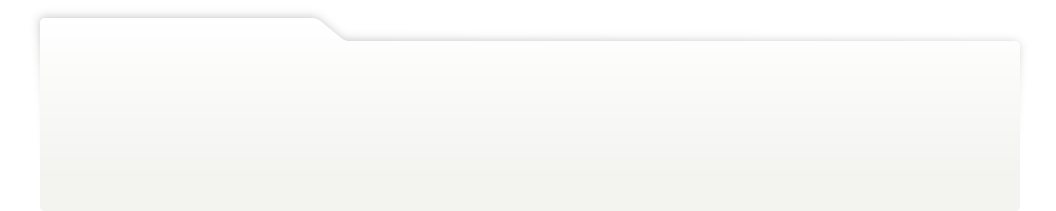
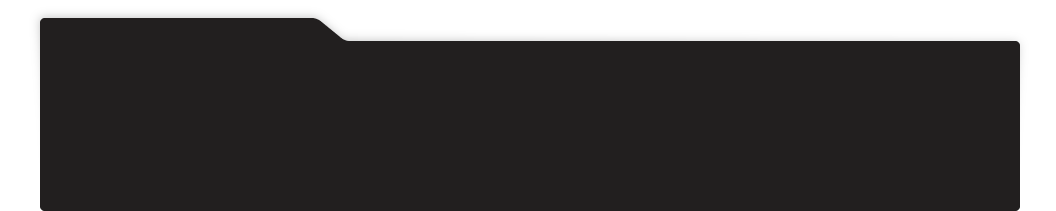
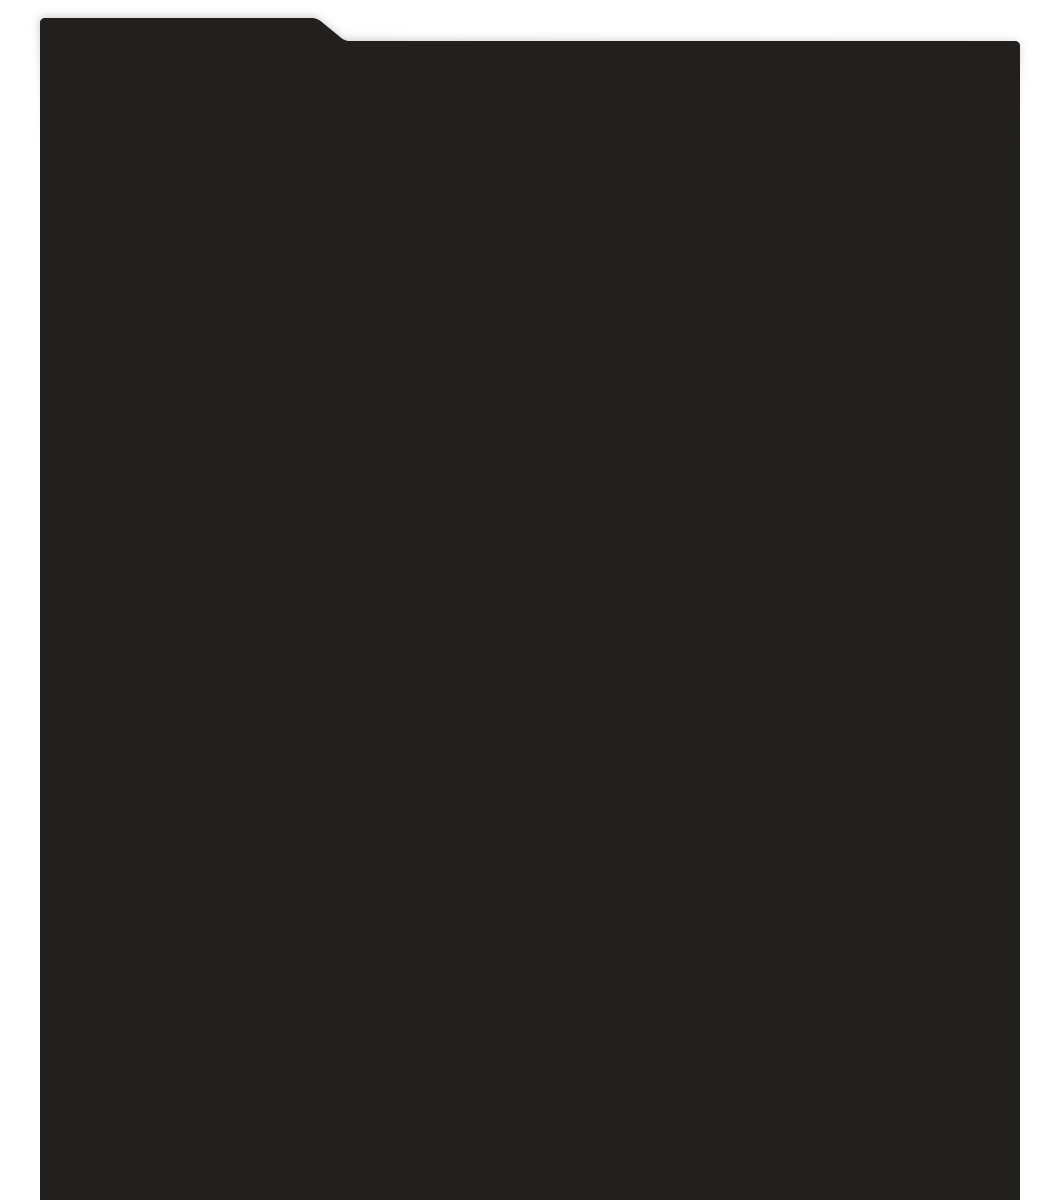
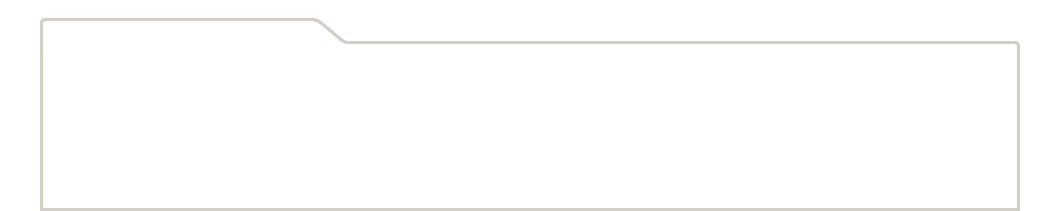
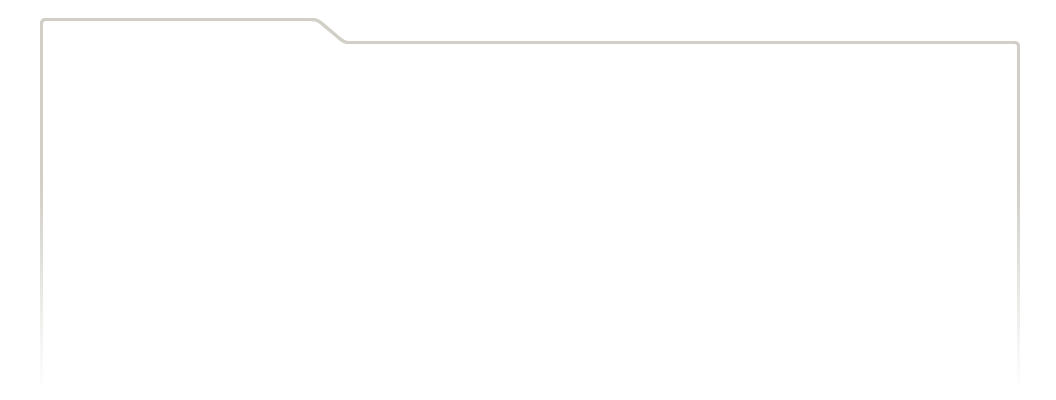
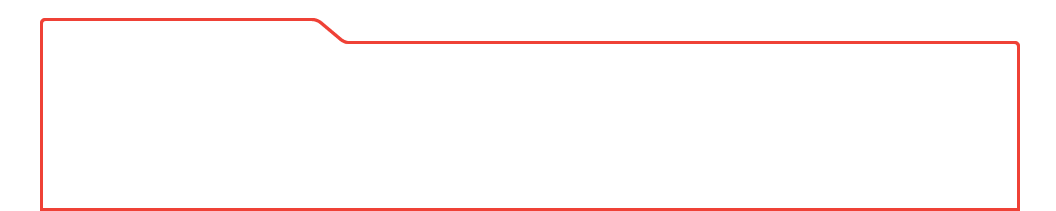
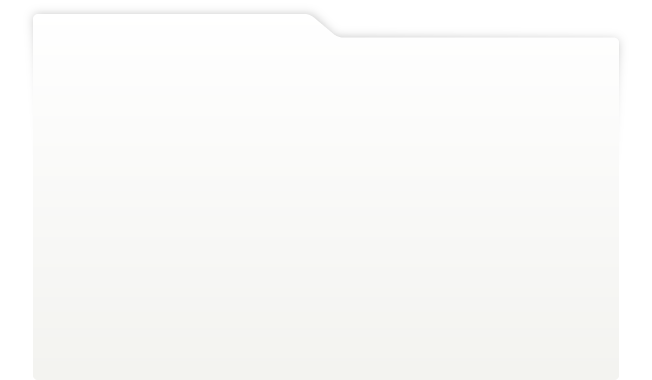
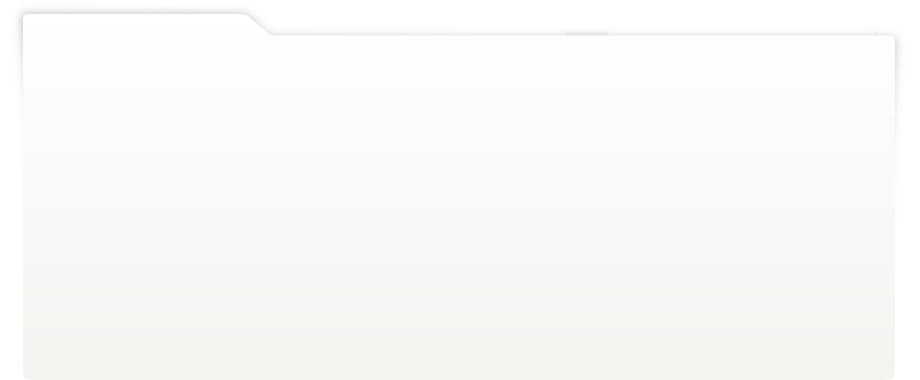
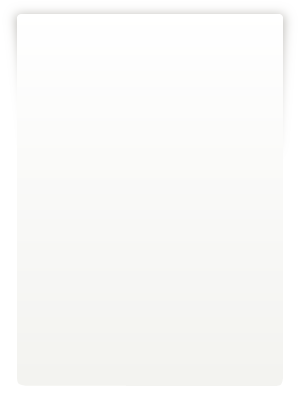
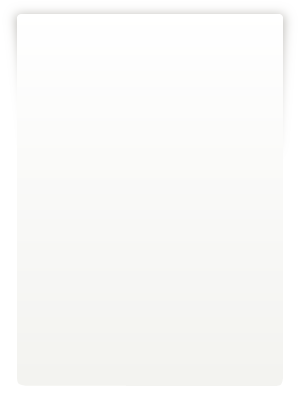
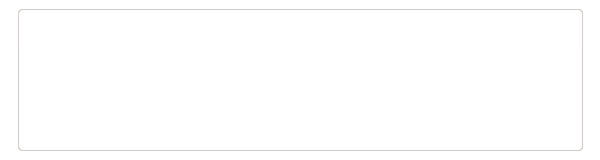
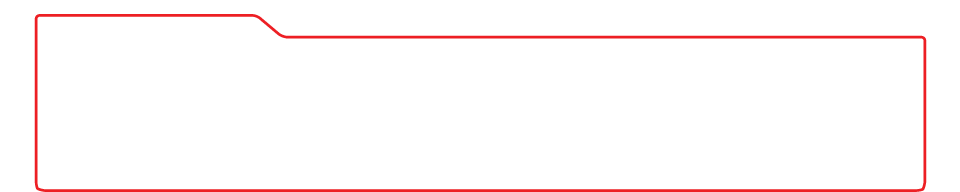
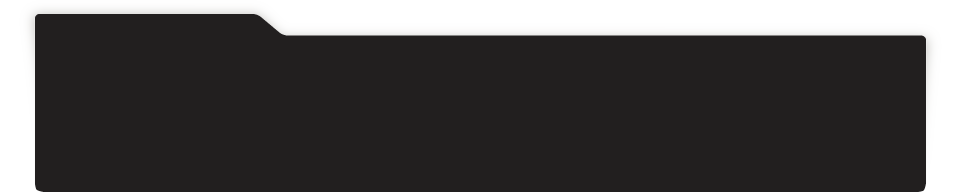
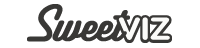
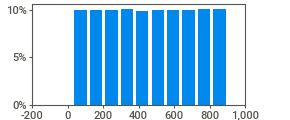
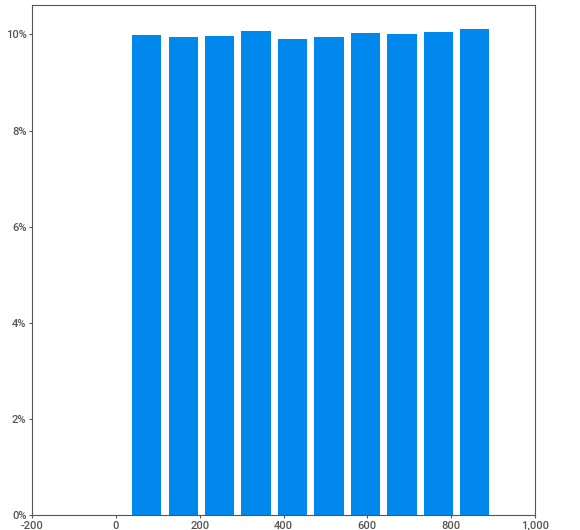
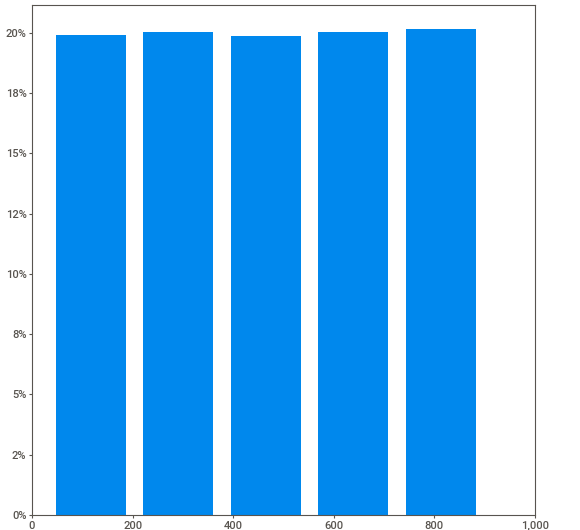
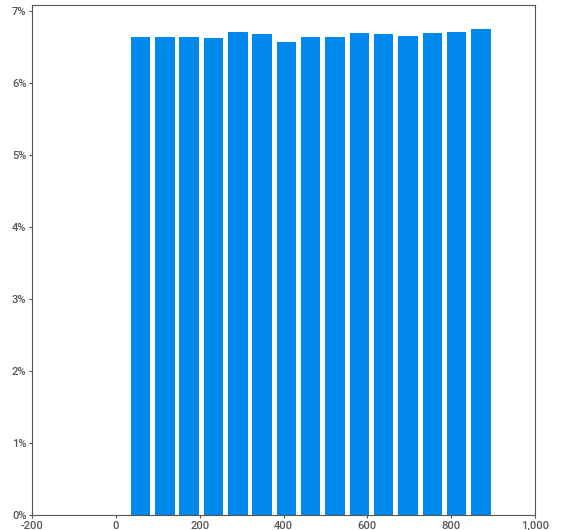
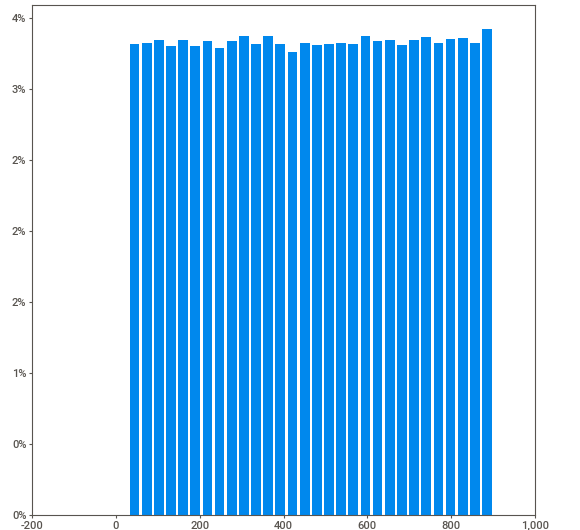
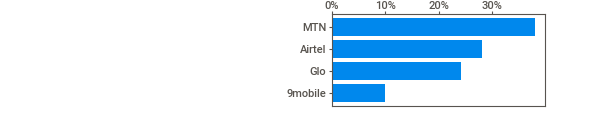
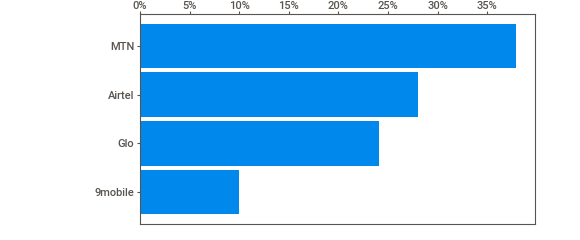
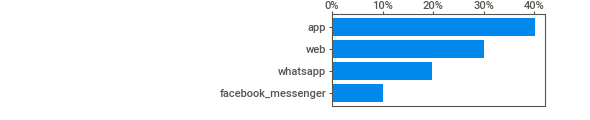
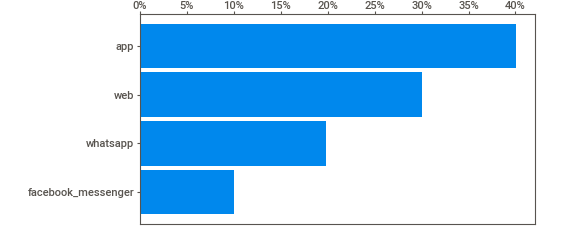
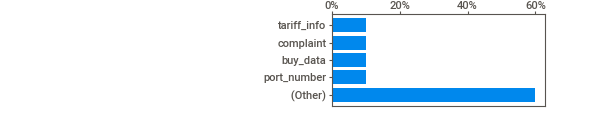
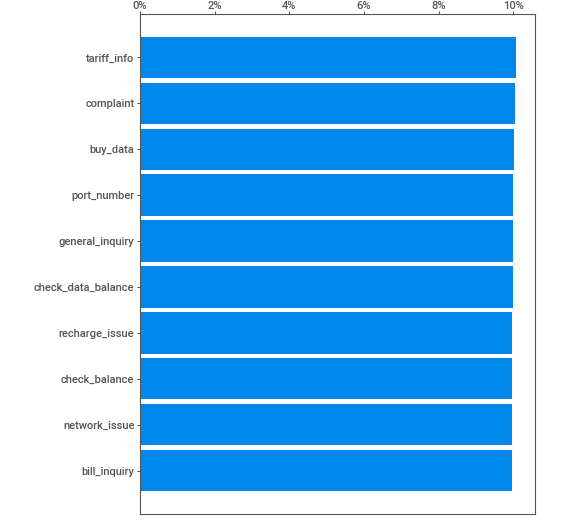
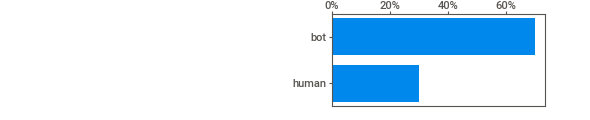
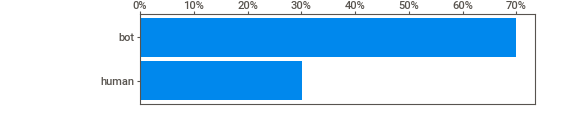
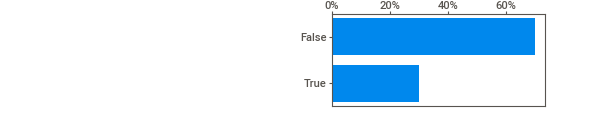
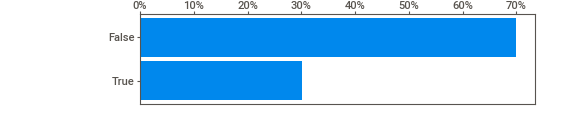
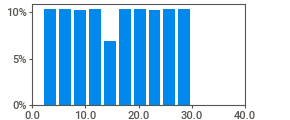
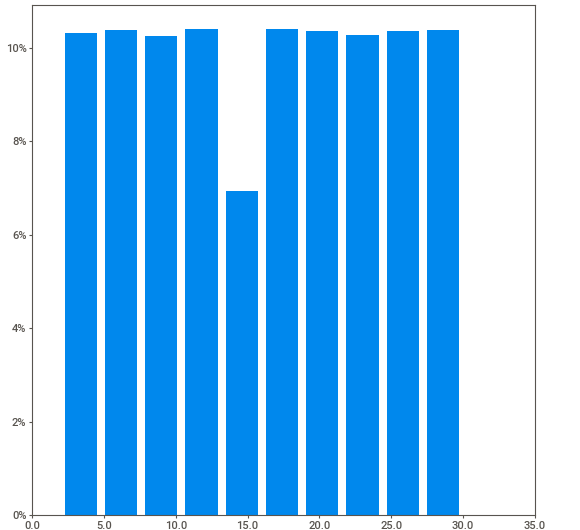
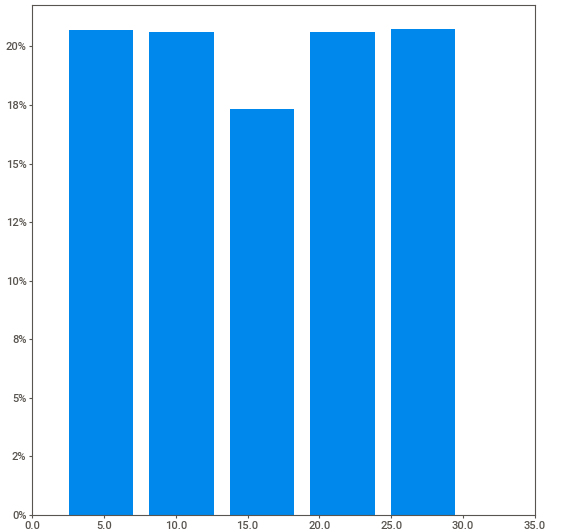
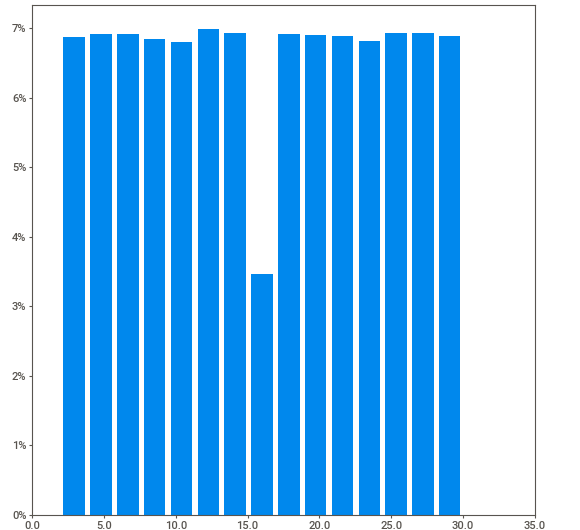
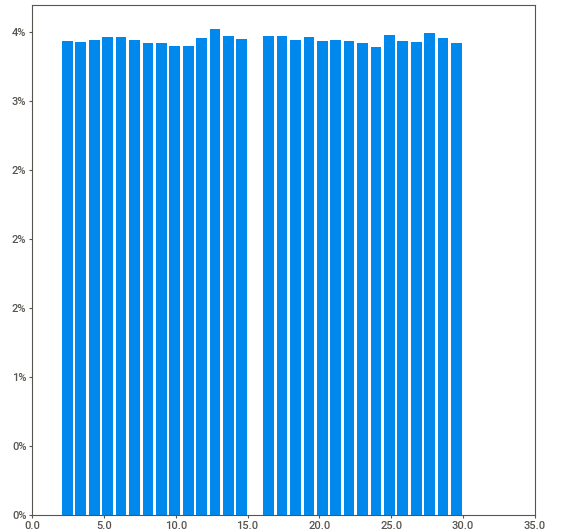
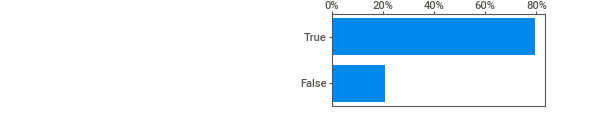
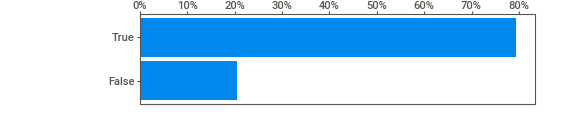
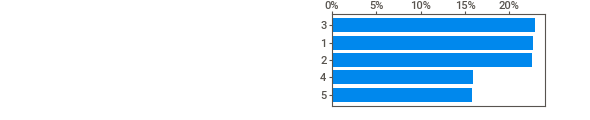
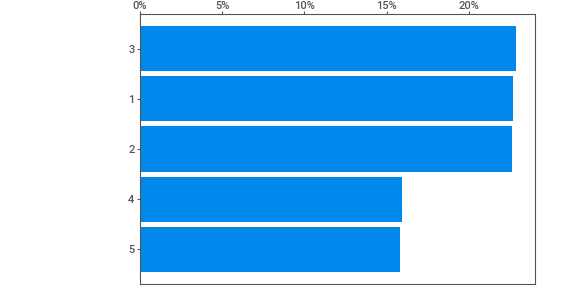
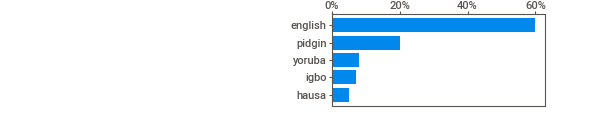
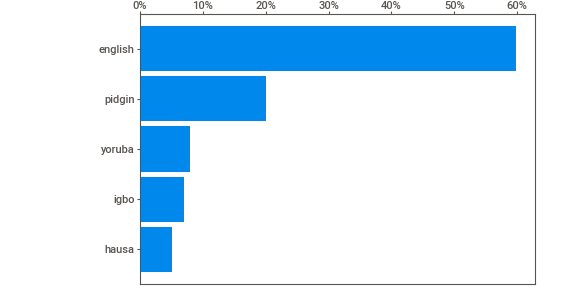
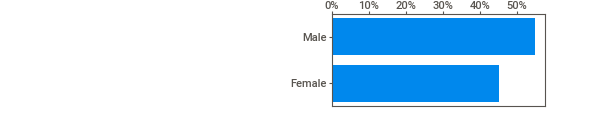
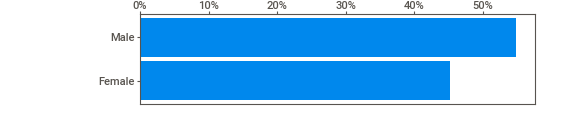
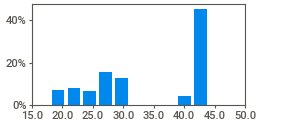
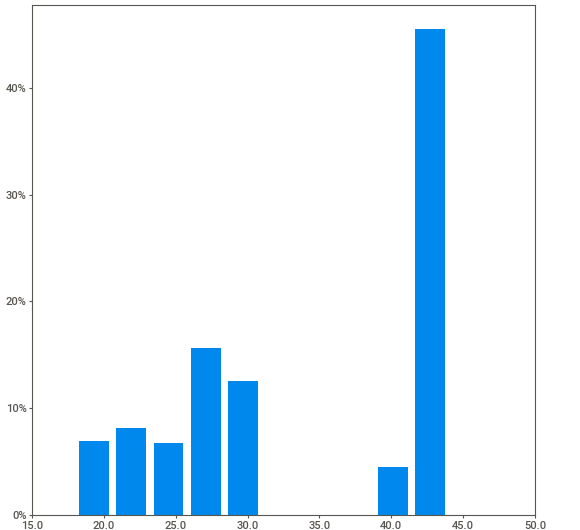
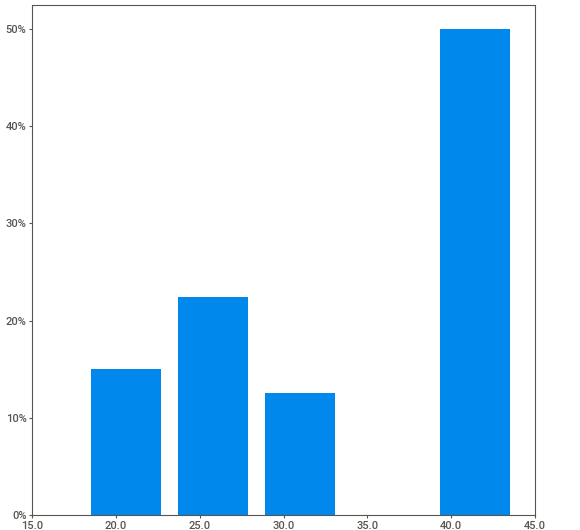
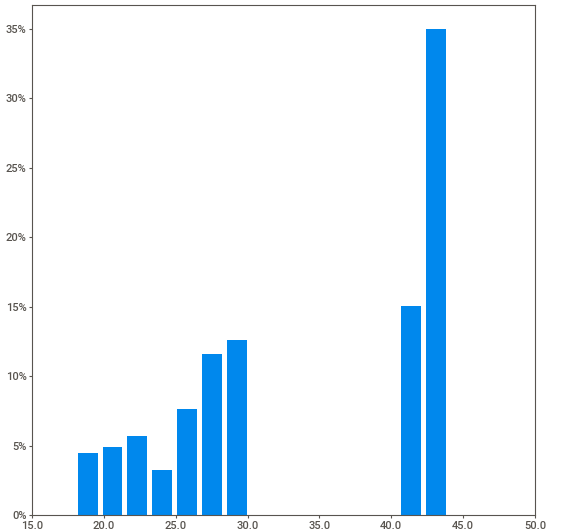
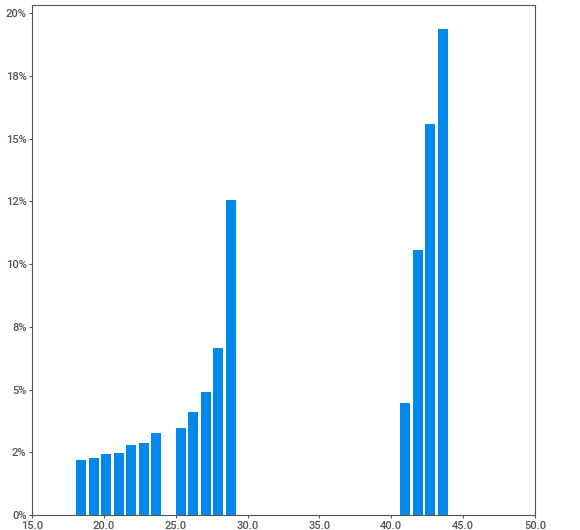
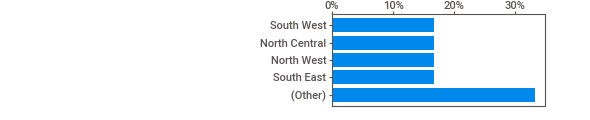
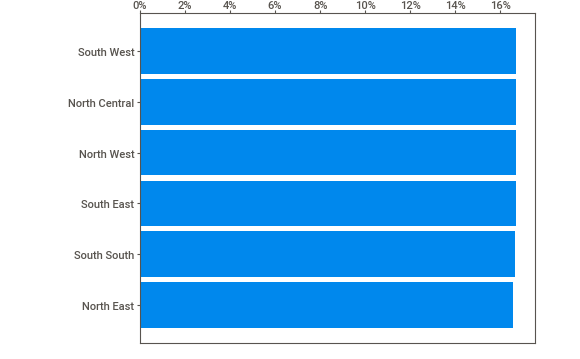
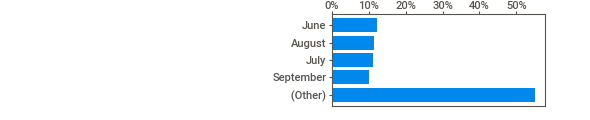
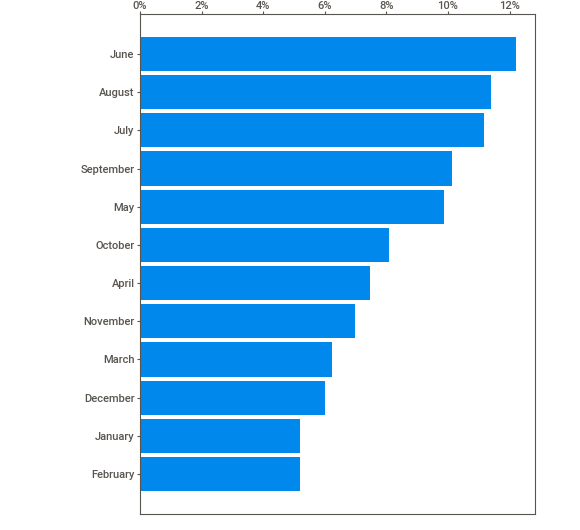
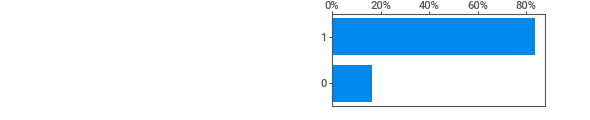
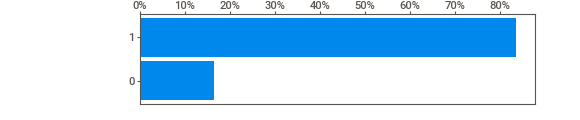
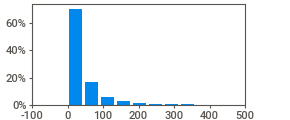
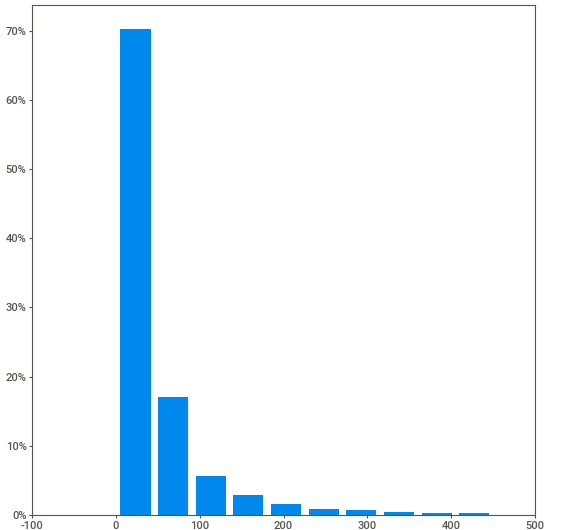
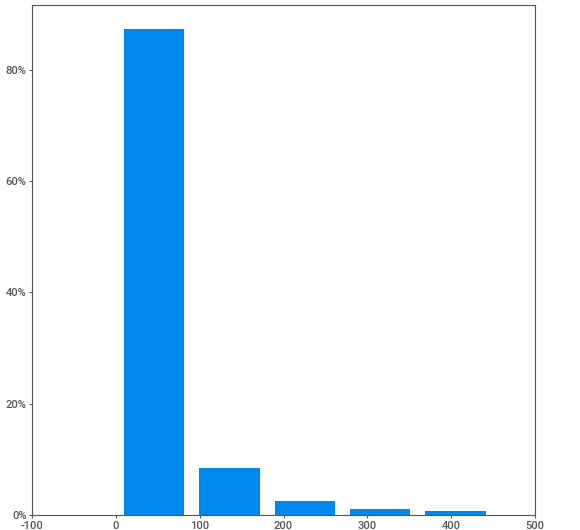
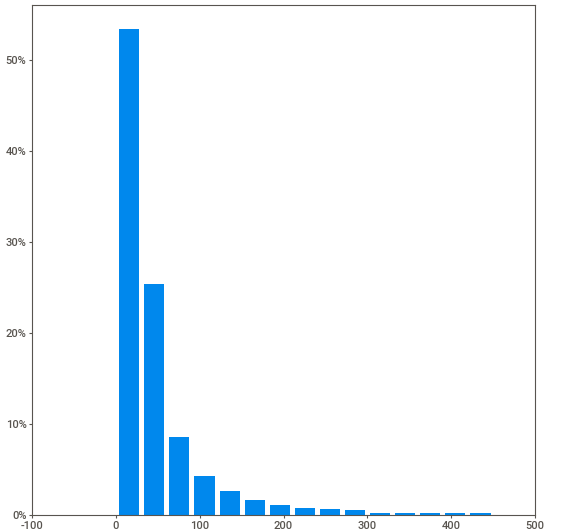
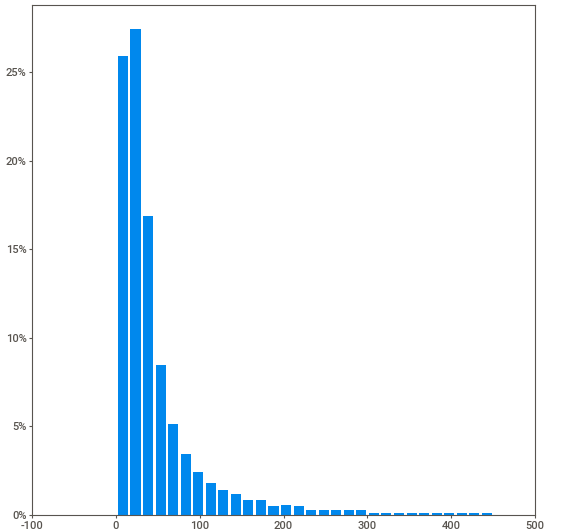
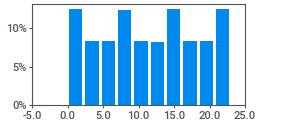
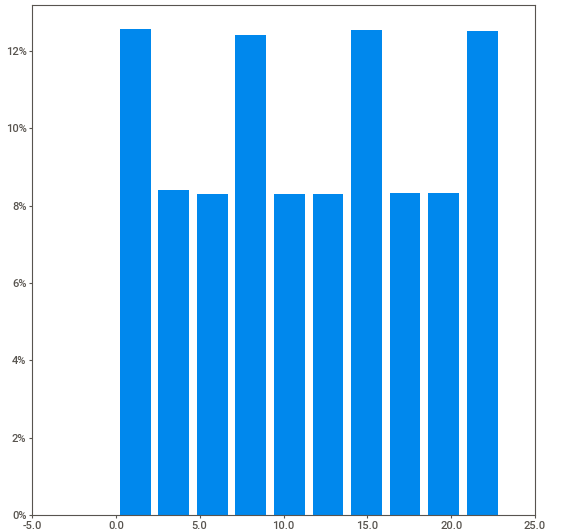
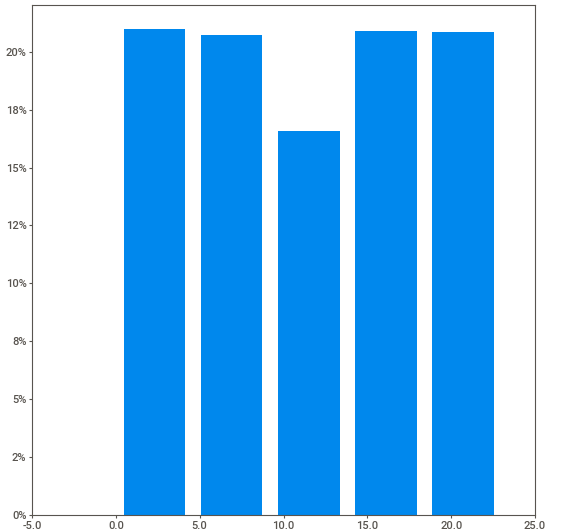
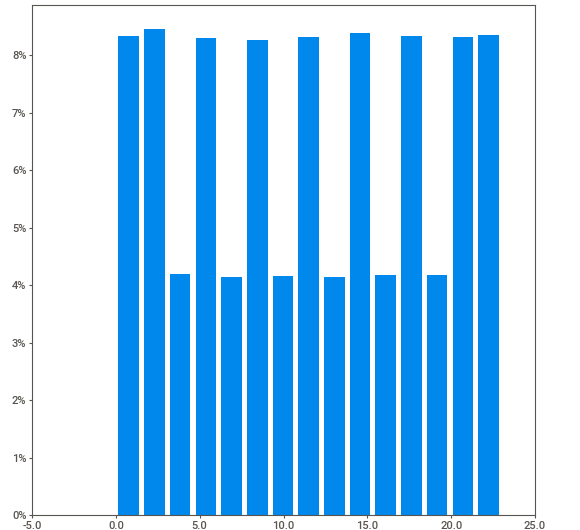
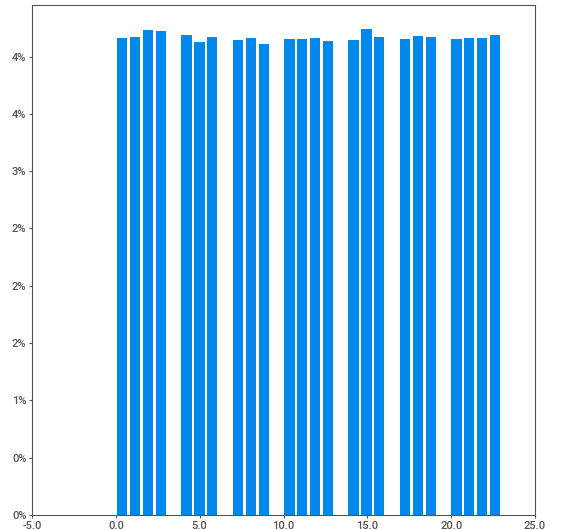
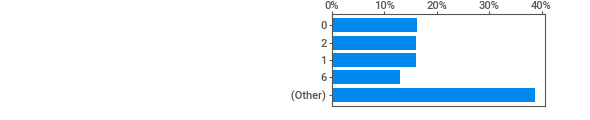
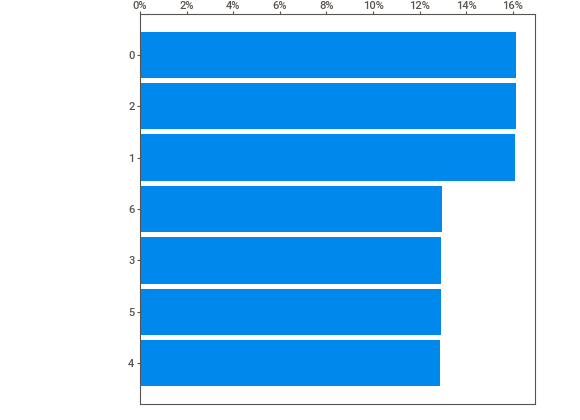
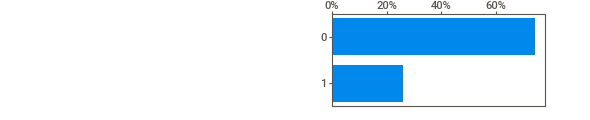
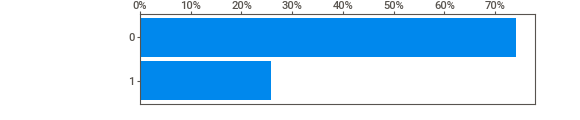
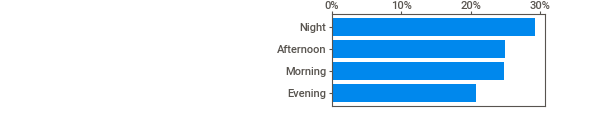
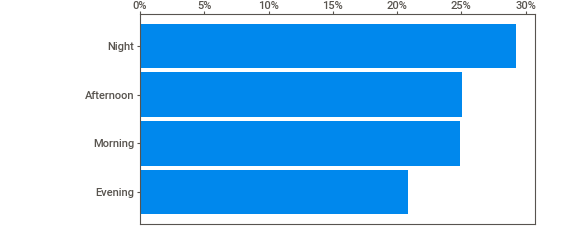
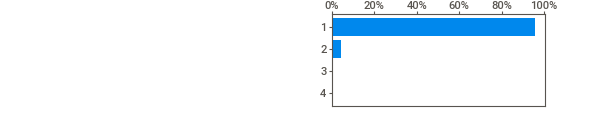
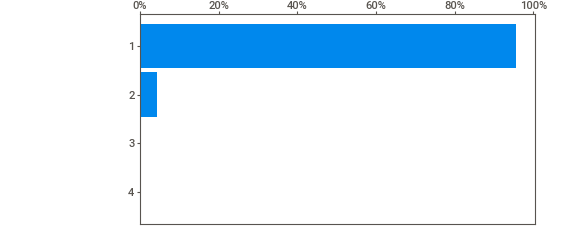
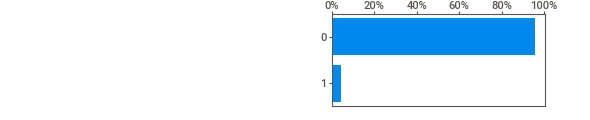
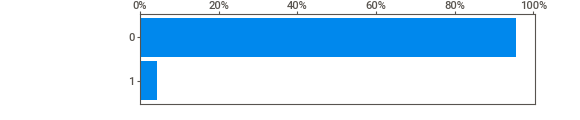
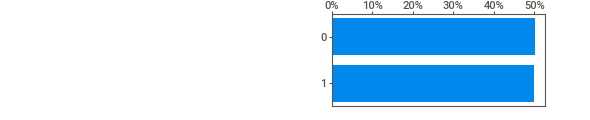
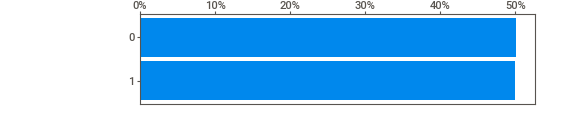
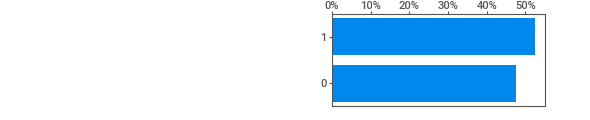
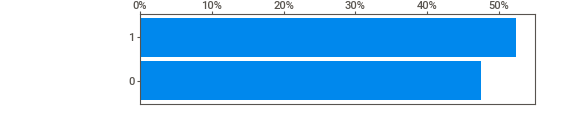
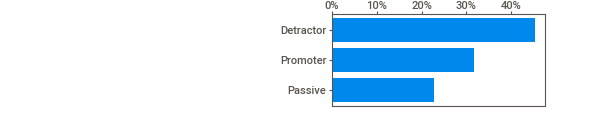
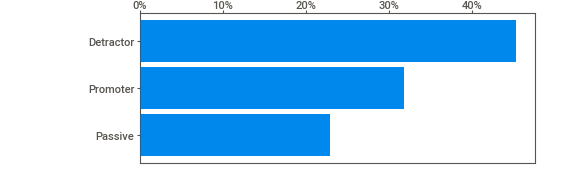
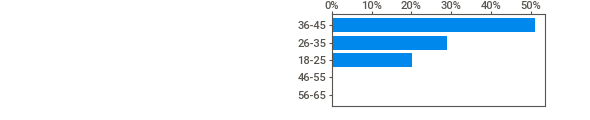
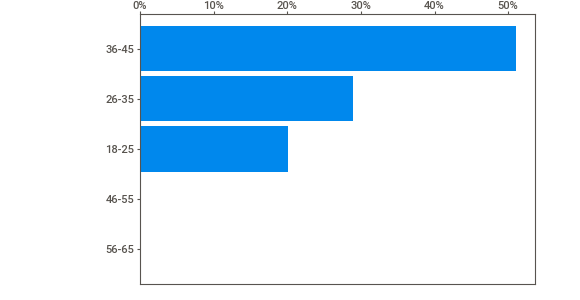
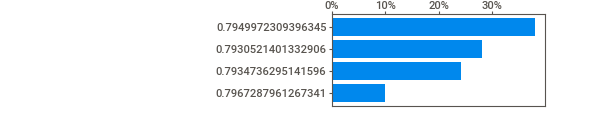
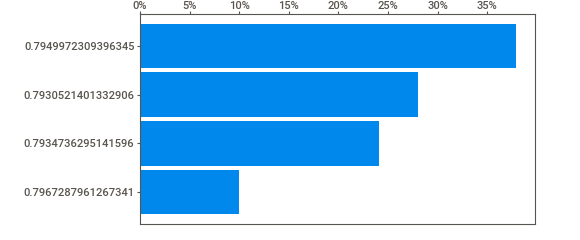
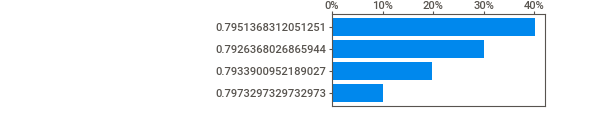
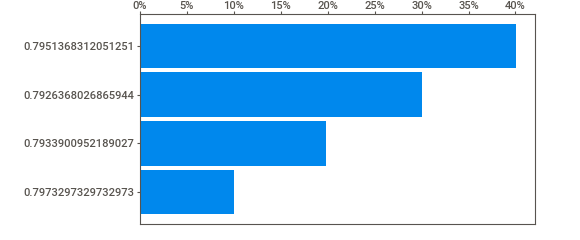
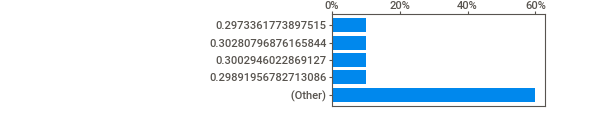
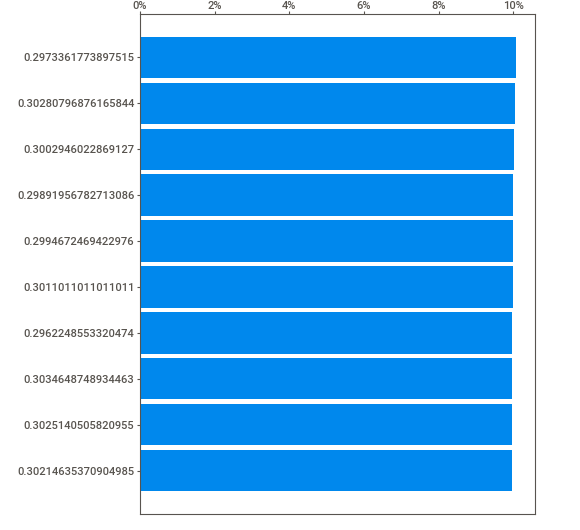
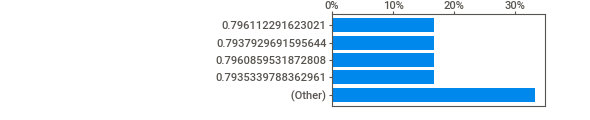
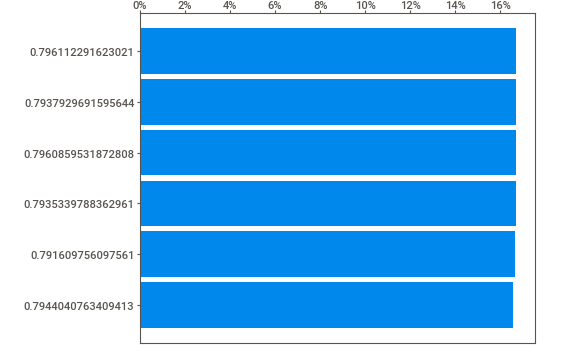
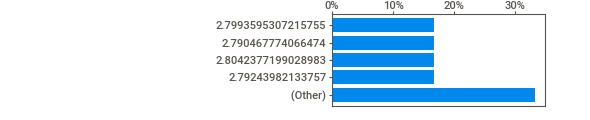
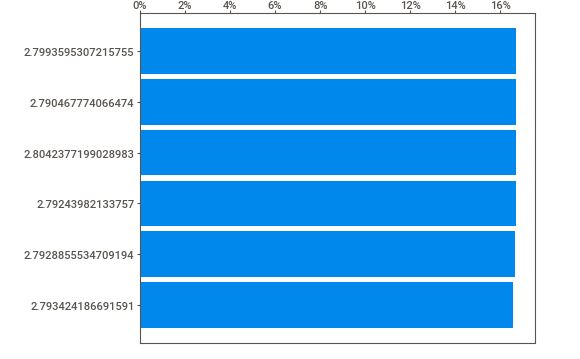
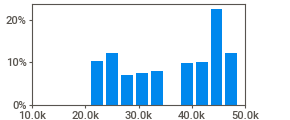
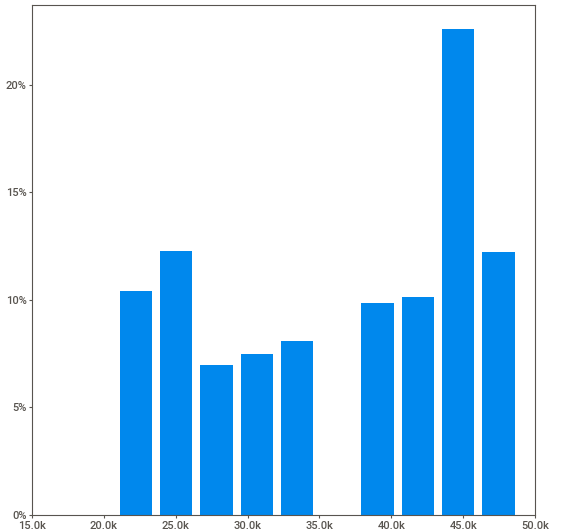
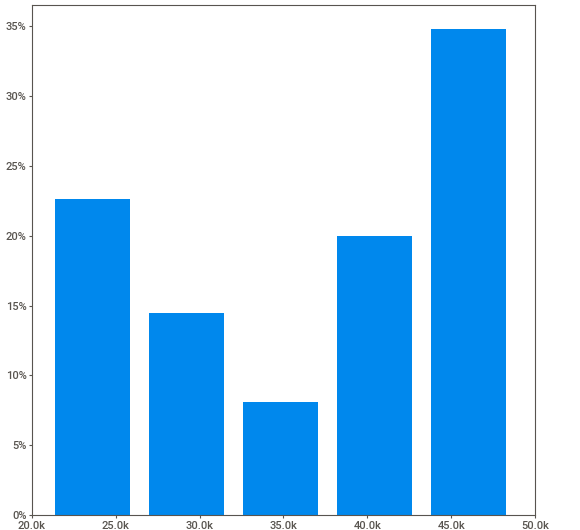
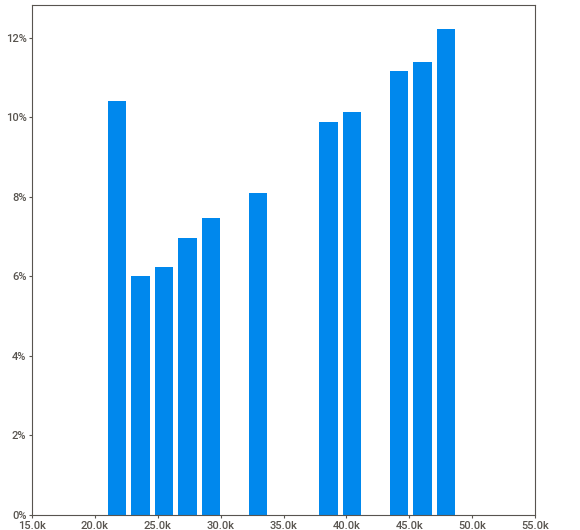
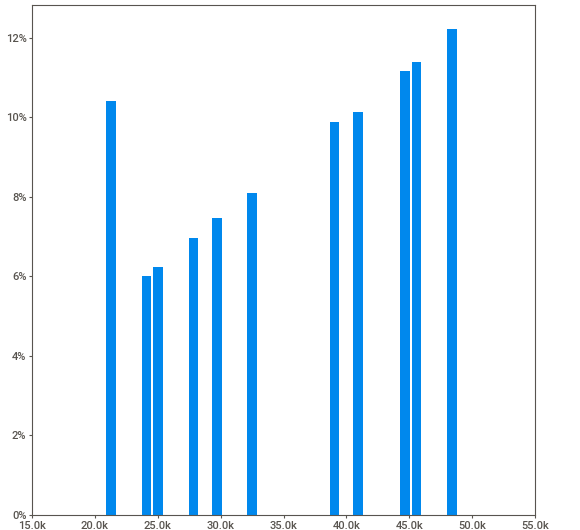
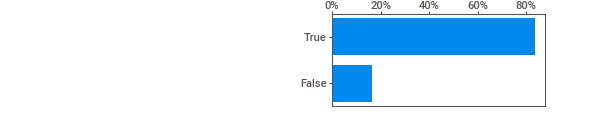
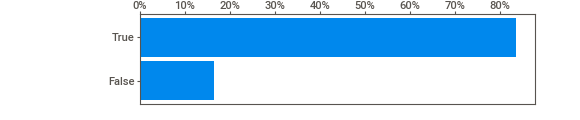
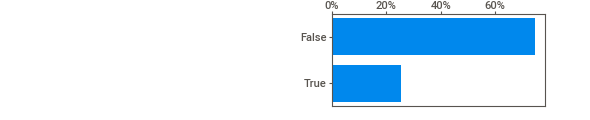
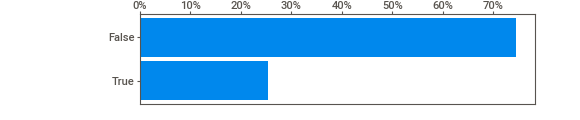
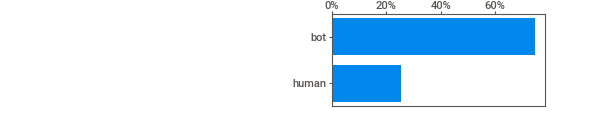
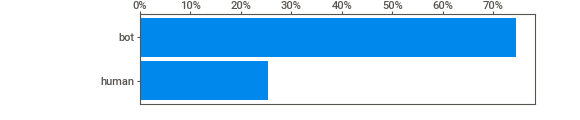
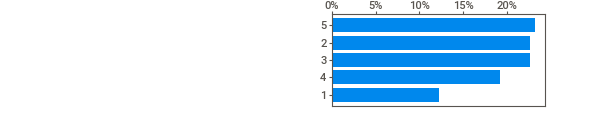
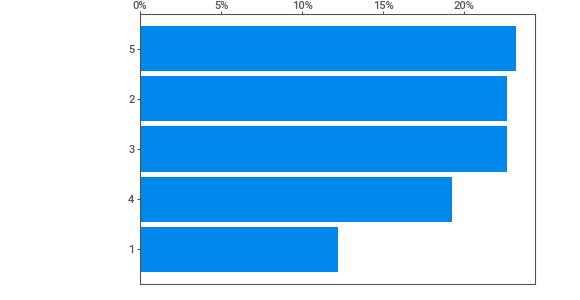
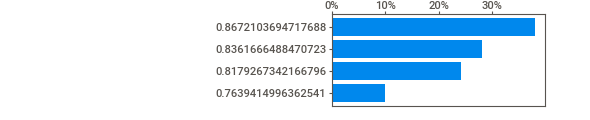
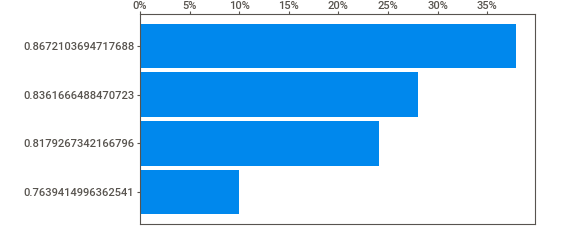
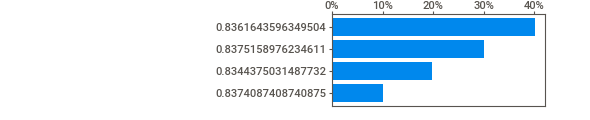
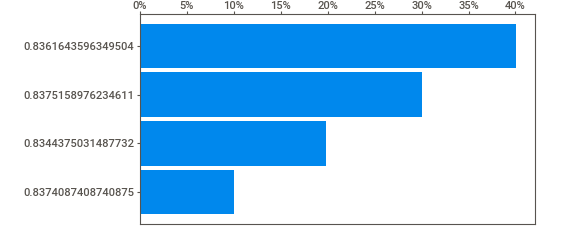
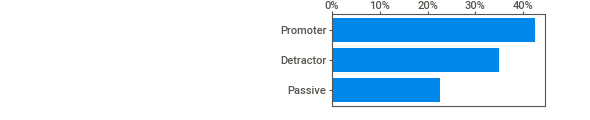
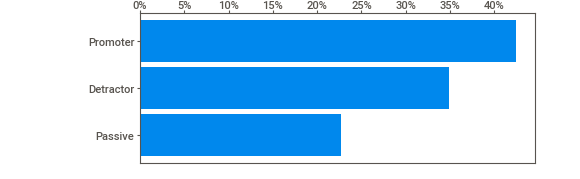
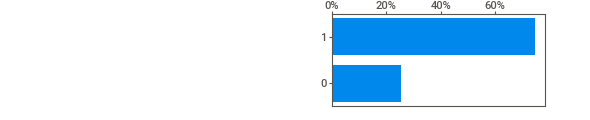
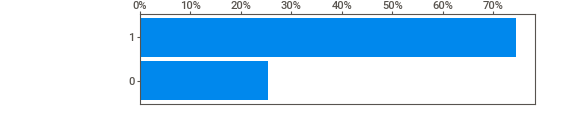
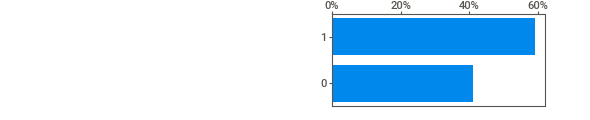
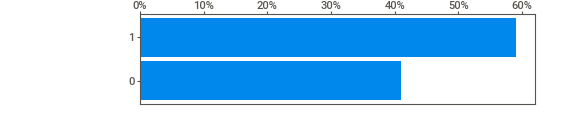
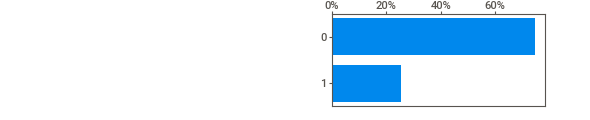
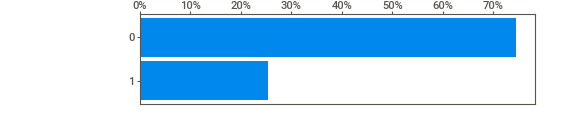
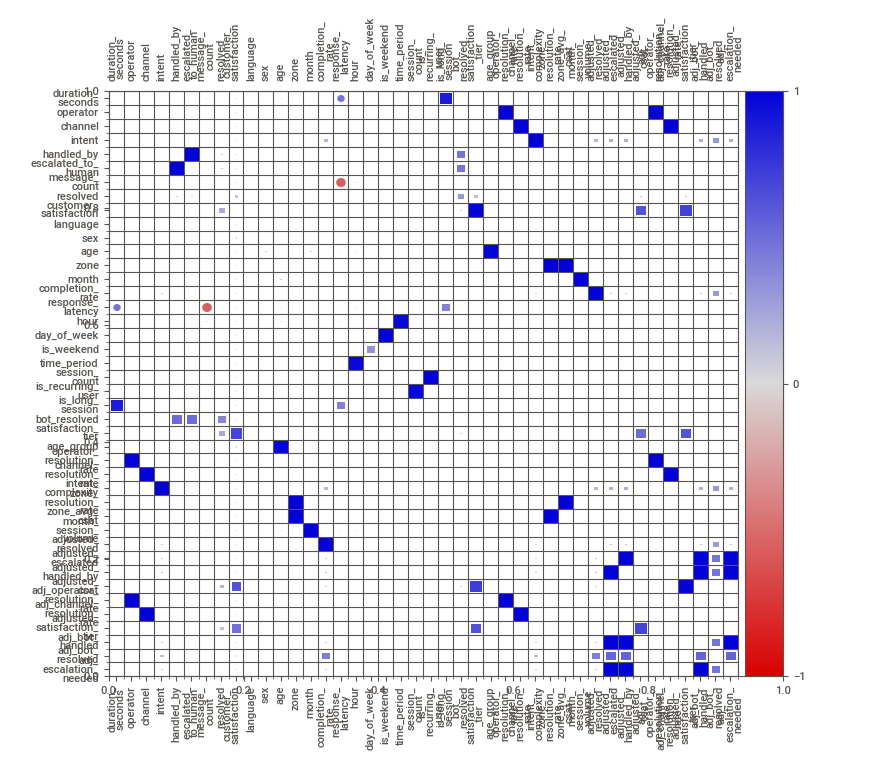
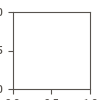

In [15]:
import IPython
IPython.display.HTML(filename='chatbot_report.html')

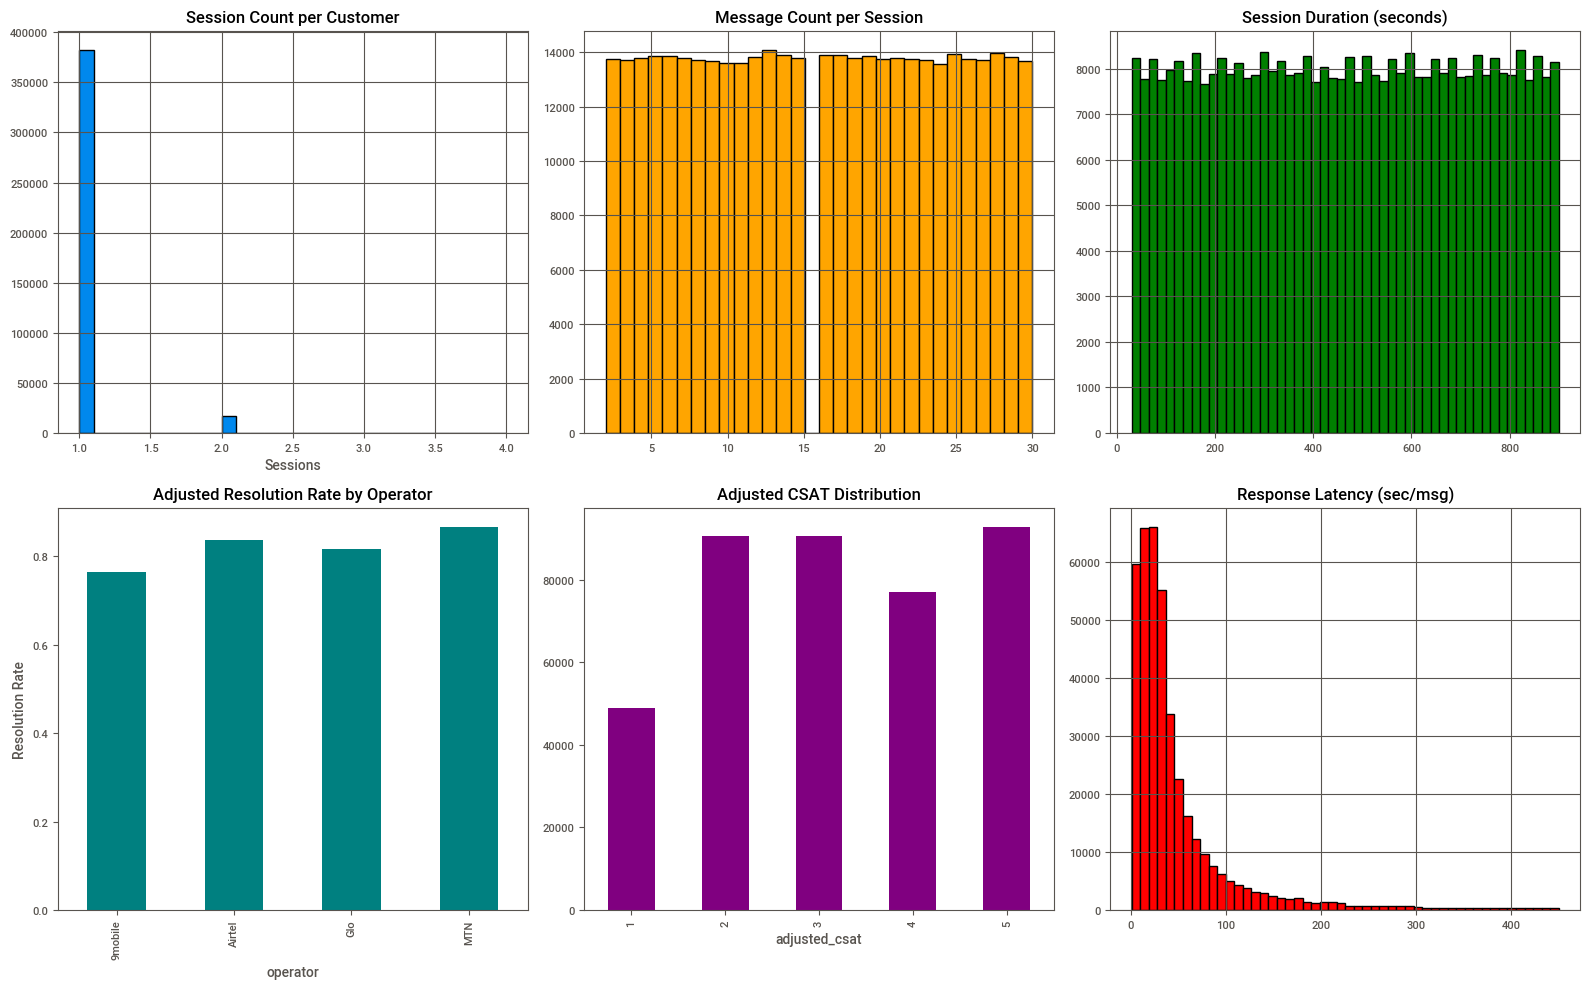

=== CORE PERFORMANCE METRICS ===
Total Sessions: 400,000
Unique Customers: 391,205
Avg Messages/Session: 16.00
Avg Duration: 465.4s
Overall Resolution Rate: 83.64%
Overall CSAT: 3.19


In [19]:
# ==================== DAY 1: CHATBOT PERFORMANCE METRICS ====================
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Session Count Distribution
df['session_count'].hist(ax=axes[0,0], bins=30, edgecolor='black')
axes[0,0].set_title('Session Count per Customer')
axes[0,0].set_xlabel('Sessions')

# 2. Message Count Distribution
df['message_count'].hist(ax=axes[0,1], bins=30, color='orange', edgecolor='black')
axes[0,1].set_title('Message Count per Session')

# 3. Duration Distribution
df['duration_seconds'].hist(ax=axes[0,2], bins=50, color='green', edgecolor='black')
axes[0,2].set_title('Session Duration (seconds)')

# 4. Resolution Rate by Operator
df.groupby('operator')['adjusted_resolved'].mean().plot(kind='bar', ax=axes[1,0], color='teal')
axes[1,0].set_title('Adjusted Resolution Rate by Operator')
axes[1,0].set_ylabel('Resolution Rate')

# 5. CSAT Distribution
df['adjusted_csat'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Adjusted CSAT Distribution')

# 6. Response Latency
df['response_latency'].hist(ax=axes[1,2], bins=50, color='red', edgecolor='black')
axes[1,2].set_title('Response Latency (sec/msg)')

plt.tight_layout()
plt.show()

# Summary Statistics
print("=== CORE PERFORMANCE METRICS ===")
print(f"Total Sessions: {len(df):,}")
print(f"Unique Customers: {df['customer_id'].nunique():,}")
print(f"Avg Messages/Session: {df['message_count'].mean():.2f}")
print(f"Avg Duration: {df['duration_seconds'].mean():.1f}s")
print(f"Overall Resolution Rate: {df['adjusted_resolved'].mean():.2%}")
print(f"Overall CSAT: {df['adjusted_csat'].mean():.2f}")

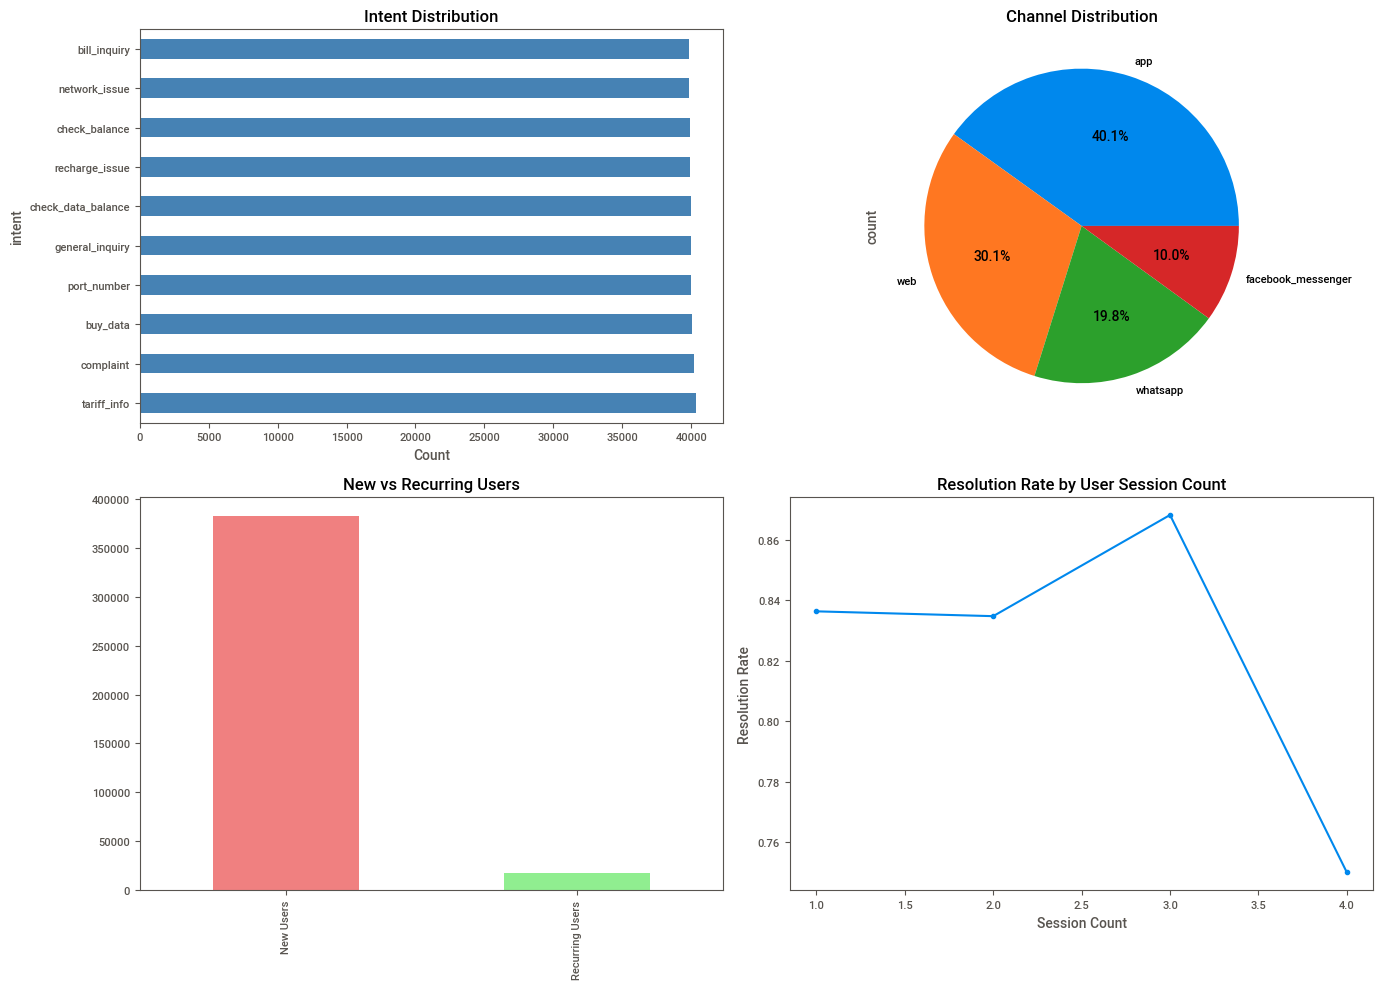

In [20]:
# ==================== DAY 2: USER BEHAVIOR & CONVERSATION MAPPING ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Intent Distribution (Conversation Types)
intent_counts = df['intent'].value_counts()
intent_counts.plot(kind='barh', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Intent Distribution')
axes[0,0].set_xlabel('Count')

# 2. Channel Usage
df['channel'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Channel Distribution')

# 3. Recurring vs New Users
recurring = df['is_recurring_user'].value_counts()
recurring.index = ['New Users', 'Recurring Users']
recurring.plot(kind='bar', ax=axes[1,0], color=['lightcoral', 'lightgreen'])
axes[1,0].set_title('New vs Recurring Users')

# 4. User Journey: Resolution by Session Count
session_resolution = df.groupby('session_count')['adjusted_resolved'].mean().head(10)
session_resolution.plot(kind='line', ax=axes[1,1], marker='o')
axes[1,1].set_title('Resolution Rate by User Session Count')
axes[1,1].set_xlabel('Session Count')
axes[1,1].set_ylabel('Resolution Rate')

plt.tight_layout()
plt.show()

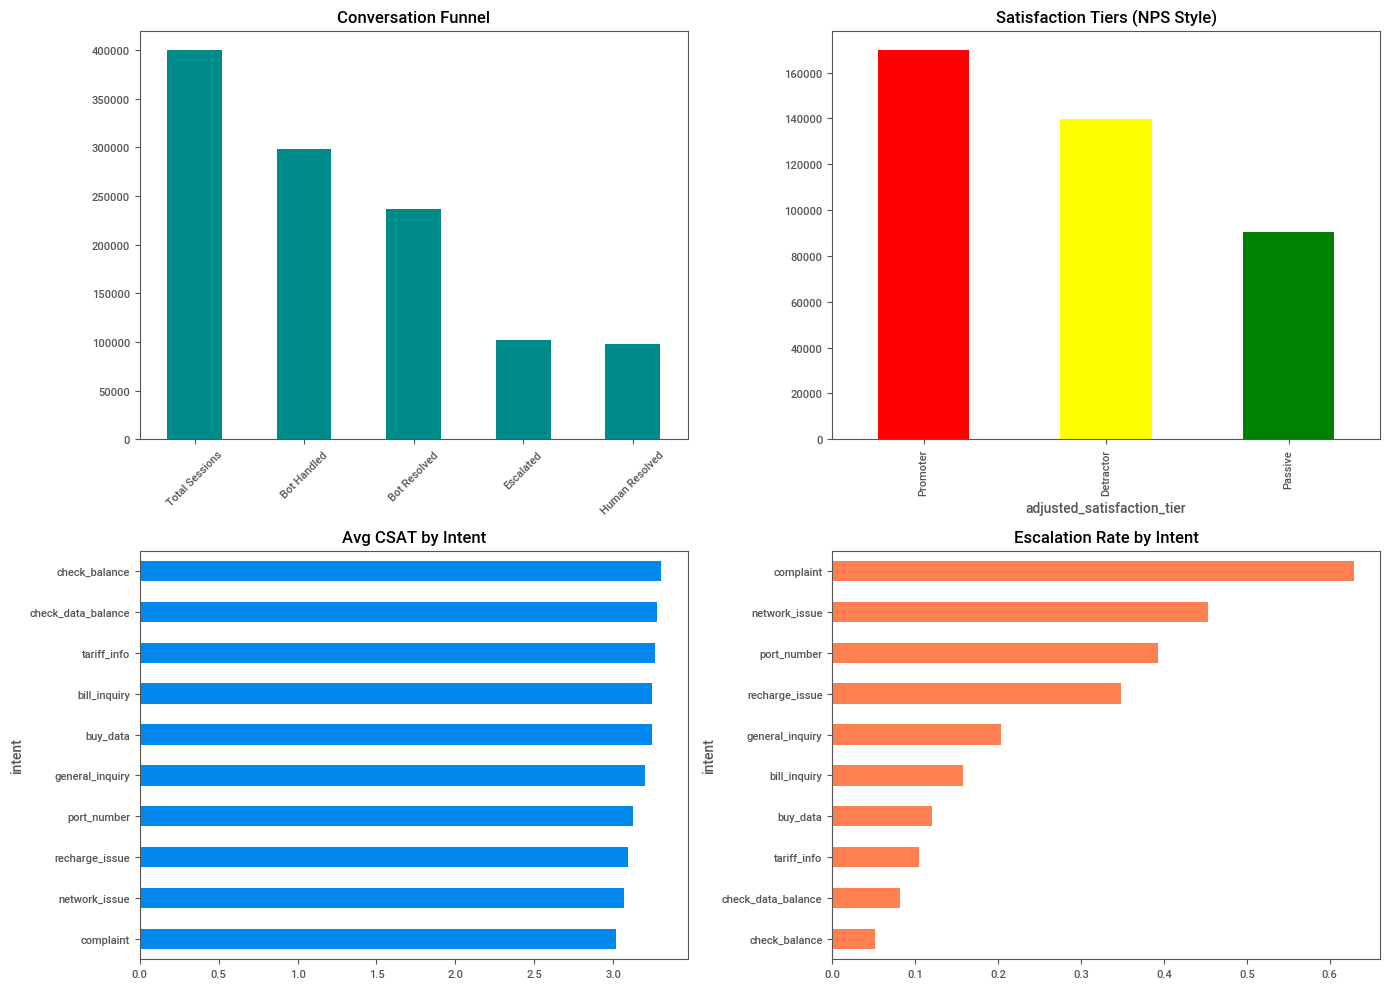

=== CONVERSATION FUNNEL METRICS ===
Bot Containment Rate: 74.57%
Bot Resolution Rate: 79.20%
Escalation Rate: 25.43%


In [21]:
# ==================== DAY 5: CONVERSATION FUNNEL & FEEDBACK ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Conversation Funnel
funnel_data = {
    'Total Sessions': len(df),
    'Bot Handled': df['adj_bot_handled'].sum(),
    'Bot Resolved': df['adj_bot_resolved'].sum(),
    'Escalated': df['adj_escalation_needed'].sum(),
    'Human Resolved': ((df['adjusted_handled_by']=='human') & df['adjusted_resolved']).sum()
}
pd.Series(funnel_data).plot(kind='bar', ax=axes[0,0], color='darkcyan')
axes[0,0].set_title('Conversation Funnel')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Satisfaction Tier Distribution (Implicit Feedback)
df['adjusted_satisfaction_tier'].value_counts().plot(kind='bar', ax=axes[0,1],
    color=['red', 'yellow', 'green'])
axes[0,1].set_title('Satisfaction Tiers (NPS Style)')

# 3. CSAT by Intent (Explicit Feedback Proxy)
df.groupby('intent')['adjusted_csat'].mean().sort_values().plot(kind='barh', ax=axes[1,0])
axes[1,0].set_title('Avg CSAT by Intent')

# 4. Escalation Rate by Intent Complexity
df.groupby('intent')['adjusted_escalated'].mean().sort_values().plot(kind='barh', ax=axes[1,1], color='coral')
axes[1,1].set_title('Escalation Rate by Intent')

plt.tight_layout()
plt.show()

# Funnel Metrics
print("=== CONVERSATION FUNNEL METRICS ===")
print(f"Bot Containment Rate: {df['adj_bot_handled'].mean():.2%}")
print(f"Bot Resolution Rate: {df['adj_bot_resolved'].sum()/df['adj_bot_handled'].sum():.2%}")
print(f"Escalation Rate: {df['adj_escalation_needed'].mean():.2%}")

/tmp/ipython-input-2175225113.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_metrics = df.groupby('time_period').agg({


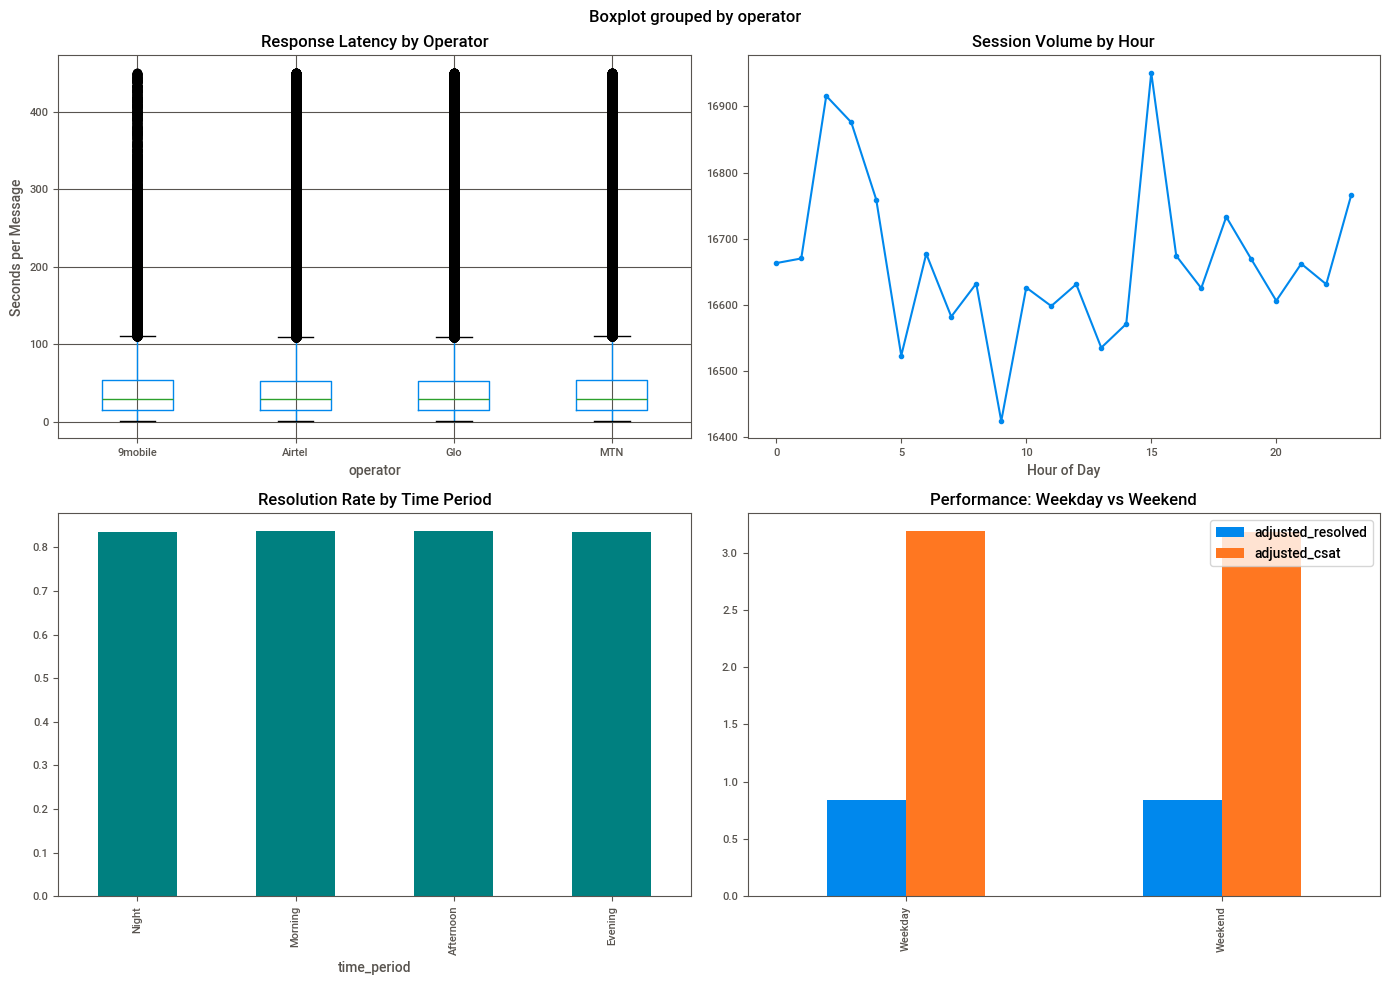

In [22]:
# ==================== DAY 6: LATENCY, THROUGHPUT & TIME PATTERNS ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Response Latency by Operator
df.boxplot(column='response_latency', by='operator', ax=axes[0,0])
axes[0,0].set_title('Response Latency by Operator')
axes[0,0].set_ylabel('Seconds per Message')

# 2. Session Volume by Hour (Throughput Pattern)
df.groupby('hour')['session_id'].count().plot(kind='line', ax=axes[0,1], marker='o')
axes[0,1].set_title('Session Volume by Hour')
axes[0,1].set_xlabel('Hour of Day')

# 3. Time Period Analysis
time_metrics = df.groupby('time_period').agg({
    'adjusted_resolved': 'mean',
    'adjusted_csat': 'mean',
    'session_id': 'count'
}).round(3)
time_metrics['adjusted_resolved'].plot(kind='bar', ax=axes[1,0], color='teal')
axes[1,0].set_title('Resolution Rate by Time Period')

# 4. Weekend vs Weekday Performance
weekend_metrics = df.groupby('is_weekend').agg({
    'adjusted_resolved': 'mean',
    'adjusted_csat': 'mean'
})
weekend_metrics.index = ['Weekday', 'Weekend']
weekend_metrics.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Performance: Weekday vs Weekend')

plt.tight_layout()
plt.show()

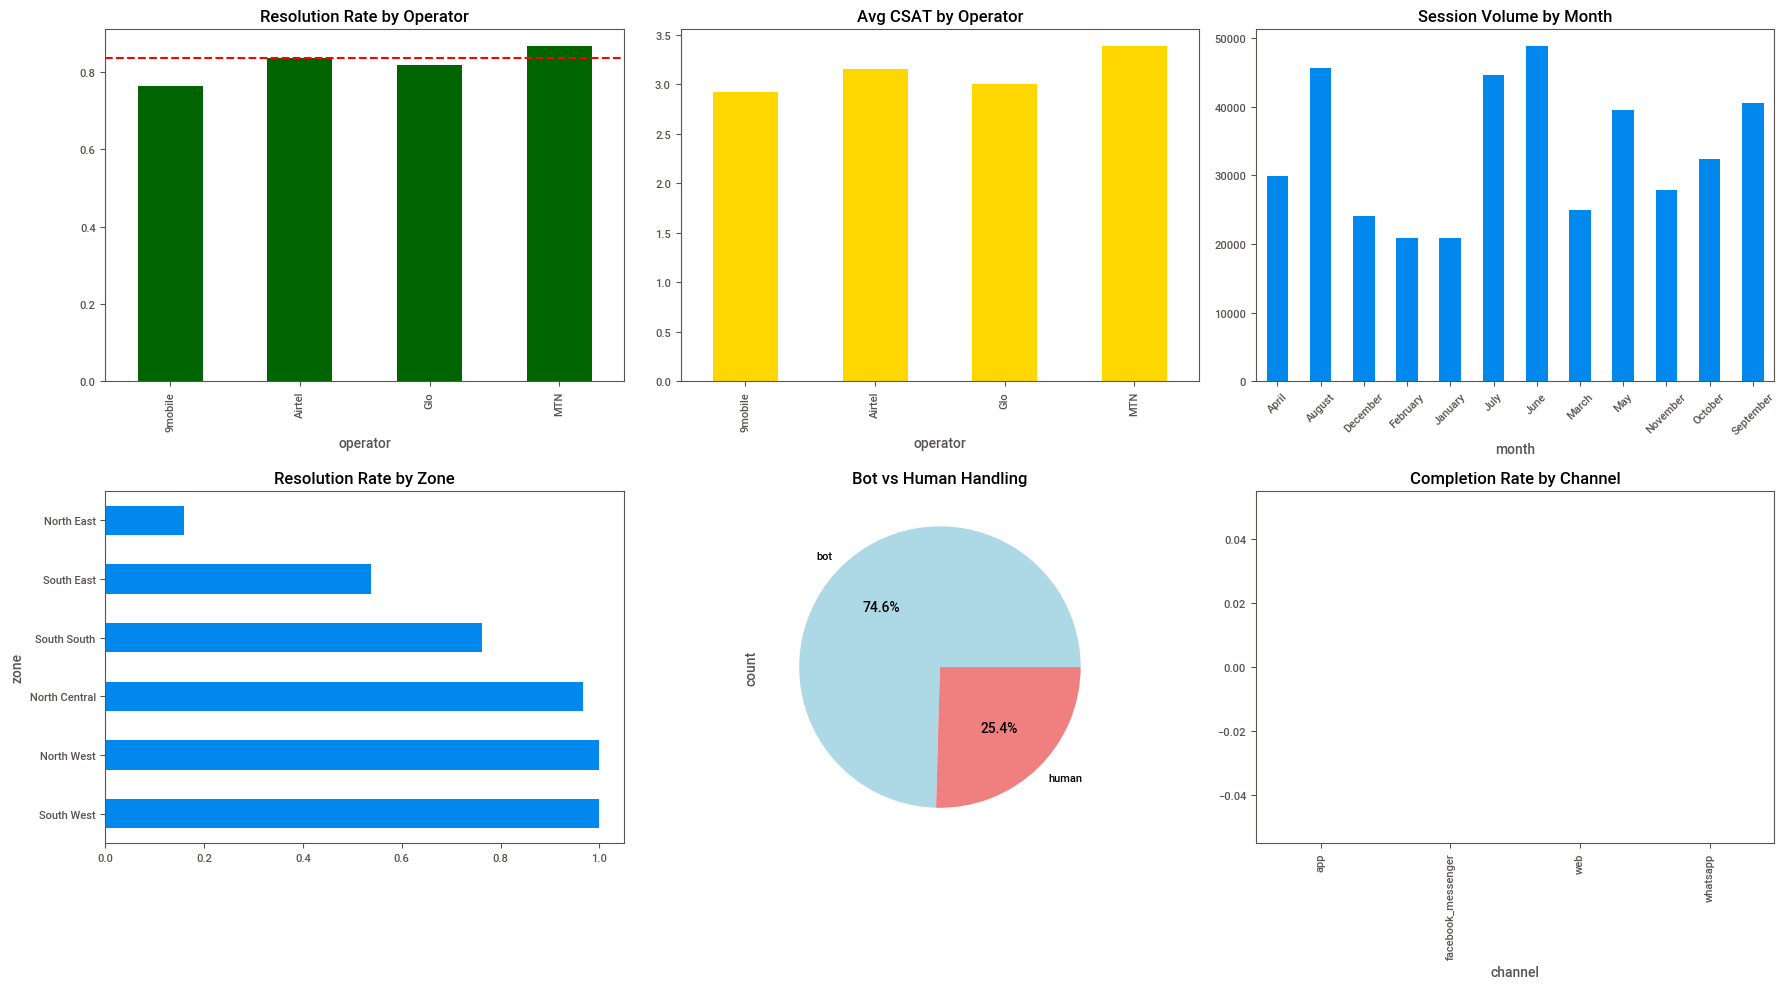

=== BUSINESS KPIs SUMMARY ===
Bot Handling Rate: 74.57%
Overall Completion Rate: 0.00%
Avg CSAT: 3.19/5

By Operator:
          adjusted_resolved  adjusted_csat
operator                                  
9mobile               0.764          2.927
Airtel                0.836          3.158
Glo                   0.818          3.006
MTN                   0.867          3.388


In [24]:
# ==================== DAY 7: BUSINESS KPIs ====================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Resolution Rate by Operator (Key Business Metric)
df.groupby('operator')['adjusted_resolved'].mean().plot(kind='bar', ax=axes[0,0], color='darkgreen')
axes[0,0].set_title('Resolution Rate by Operator')
axes[0,0].axhline(y=df['adjusted_resolved'].mean(), color='red', linestyle='--', label='Overall Avg')

# 2. CSAT by Operator
df.groupby('operator')['adjusted_csat'].mean().plot(kind='bar', ax=axes[0,1], color='gold')
axes[0,1].set_title('Avg CSAT by Operator')

# 3. Monthly Session Volume (Retention Proxy)
df.groupby('month')['session_id'].count().plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('Session Volume by Month')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Zone Performance (Regional Analysis)
zone_metrics = df.groupby('zone').agg({
    'adjusted_resolved': 'mean',
    'adjusted_csat': 'mean'
}).sort_values('adjusted_resolved', ascending=False)
zone_metrics['adjusted_resolved'].plot(kind='barh', ax=axes[1,0])
axes[1,0].set_title('Resolution Rate by Zone')

# 5. Bot ROI: Cost Avoidance (Sessions handled by bot)
handled_by_counts = df['adjusted_handled_by'].value_counts()
handled_by_counts.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
axes[1,1].set_title('Bot vs Human Handling')

# 6. Completion Rate by Channel
df.groupby('channel')['completion_rate'].mean().plot(kind='bar', ax=axes[1,2], color='purple')
axes[1,2].set_title('Completion Rate by Channel')

plt.tight_layout()
plt.show()

# Business KPI Summary
print("=== BUSINESS KPIs SUMMARY ===")
print(f"Bot Handling Rate: {(df['adjusted_handled_by']=='bot').mean():.2%}")
print(f"Overall Completion Rate: {df['completion_rate'].mean():.2%}")
print(f"Avg CSAT: {df['adjusted_csat'].mean():.2f}/5")
print("\nBy Operator:")
print(df.groupby('operator')[['adjusted_resolved', 'adjusted_csat']].mean().round(3))